# Hotel customer comments analysis

## Import library

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import operator
import re
import nltk
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find
import sklearn
import sklearn.metrics as metrics

## Data overview

I crawl a specific dataset for hotels reviews on Tripadvisor in Calgary, Canada. I used a tool called Tripadvisor Crawler. It is a very handy tool, however, it is a little bit unstable.

In this project we also familiarize ourselves with the nltk library and an nltk sentiment analysis package called Vader.

Reference: https://github.com/aesuli/trip-advisor-crawler.

In [0]:
hotelDf = pd.read_csv('reviews.csv', header = None)
# if not indicate 'header = None', it will skip the first line not reading
hotelDf.columns=['idNum','filePath','hotelName','reviewColumn','ratingScore','groundTruth']
hotelDf.head()

,idNum,filePath,hotelName,reviewColumn,ratingScore,groundTruth
0,516719059,data4\ca\154913\10259142\516733311.html,Element Calgary Airport,Arrived to check into a King Executive Suite A...,2,negative
1,531560410,data4\ca\154913\10259142\535933244.html,Element Calgary Airport,I really enjoyed my stay here. The room had a ...,5,positive
2,535933244,data4\ca\154913\10259142\537074672.html,Element Calgary Airport,We stayed one night in this new hotel and it's...,5,positive
3,537074672,data4\ca\154913\10259142\538137131.html,Element Calgary Airport,Stayed at this hotel for business trip purpose...,5,positive
4,538137131,data4\ca\154913\10259142\540014523.html,Element Calgary Airport,Very clean. Modern and bright. GREAT mattress ...,4,positive


In [0]:
hotelDf.shape

(3612, 6)

In [0]:
# if wanna compute the avg of the star rating, binarize it to like = 1 (rating = 4,5) and dislike = 0 (rating = 1,2,3)
hotelDF = hotelDf.copy()
hotelDF['ratingScore'] = hotelDf['ratingScore'].map(lambda x: 1 if x>3 else 0)

In [0]:
# method2 - easier
# http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html
# hotelDf_new = hotelDf.replace({[4,5]: 1, [1,2,3]: 0})

In [0]:
# after running Vader, there is a bug: 'float' object has no attribute 'encode'
# that means my data (reviews column) has null values, which leading to treating nan as float
# so we need to analyse and drop all the null values
hotelDf['reviewColumn'].isnull().sum()

193

In [0]:
hotelDF = hotelDF.dropna()

In [0]:
# this step is to deal with the problem that index of new df after drop nan different with review vader df index
# because after drop null, the index is removed
# but the vader sentiment score df is normal df, index from 0 to last, none index empty
# if not adjust the orignal df index, the 
hotelDF = hotelDF.reset_index()
hotelDF = hotelDF.drop(columns = ['index'])
# or a better method:
# https://stackoverflow.com/questions/40755680/how-to-reset-index-pandas-dataframe-after-dropna-pandas-dataframe

In [0]:
hotelDF.head()

,idNum,filePath,hotelName,reviewColumn,ratingScore,groundTruth
0,516719059,data4\ca\154913\10259142\516733311.html,Element Calgary Airport,Arrived to check into a King Executive Suite A...,0,negative
1,531560410,data4\ca\154913\10259142\535933244.html,Element Calgary Airport,I really enjoyed my stay here. The room had a ...,1,positive
2,535933244,data4\ca\154913\10259142\537074672.html,Element Calgary Airport,We stayed one night in this new hotel and it's...,1,positive
3,537074672,data4\ca\154913\10259142\538137131.html,Element Calgary Airport,Stayed at this hotel for business trip purpose...,1,positive
4,538137131,data4\ca\154913\10259142\540014523.html,Element Calgary Airport,Very clean. Modern and bright. GREAT mattress ...,1,positive


## Sentiment analysis

Compute average Vader sentiment and average ground truth rating per hotel.

Rank hotels by avg ground-truth sentiment and avg Vader sentiment score.

In [0]:
# To compute avg Vader sentiment, we should first compute the Vader score for each review
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=True, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    # process bar for better tracking
    for sentence in tqdm(sentences):
        ss = sid.polarity_scores(sentence)
        pdlist.append([sentence]+[ss['compound']]) # only get the compound score,
        # there are other scores, called neutral and negative and positive
    reviewDf = pd.DataFrame(pdlist)
    reviewDf.columns = columns
    return reviewDf

In [0]:
reviews = hotelDF['reviewColumn'].values
reviewDF = evalSentences(reviews, to_df=True, columns=['Review','VaderScore'])
reviewDF.head()

100%|██████████| 3419/3419 [00:04<00:00, 770.39it/s]


,Review,VaderScore
0,Arrived to check into a King Executive Suite A...,0.2413
1,I really enjoyed my stay here. The room had a ...,0.9701
2,We stayed one night in this new hotel and it's...,0.9939
3,Stayed at this hotel for business trip purpose...,0.9530
4,Very clean. Modern and bright. GREAT mattress ...,0.9090


In [0]:
newdf = hotelDF[['hotelName','ratingScore', 'groundTruth']].join(reviewDF)

In [0]:
newdf.head()

,hotelName,ratingScore,groundTruth,Review,VaderScore
0,Element Calgary Airport,0,negative,Arrived to check into a King Executive Suite A...,0.2413
1,Element Calgary Airport,1,positive,I really enjoyed my stay here. The room had a ...,0.9701
2,Element Calgary Airport,1,positive,We stayed one night in this new hotel and it's...,0.9939
3,Element Calgary Airport,1,positive,Stayed at this hotel for business trip purpose...,0.9530
4,Element Calgary Airport,1,positive,Very clean. Modern and bright. GREAT mattress ...,0.9090


In [0]:
hotelnames = newdf['hotelName'].unique()

In [0]:
len(hotelnames)

70

### Top and bottom 5 hotels ranked by Vader score

In [0]:
def getHotelRank(df, measure):# the argument can be only df, then the measure is default, which is vader score
    # measure is an argument, but it has default value, you can even not set this argument, but df is the argument you must define
    hotelRating = []
    for hotel in hotelnames:
        itemDf = df.loc[df['hotelName']==hotel]
        hotelRating.append([hotel,itemDf[measure].mean()])
    hotelRatingDf = pd.DataFrame(hotelRating)
    if measure == 'VaderScore':
        hotelRatingDf.columns=['hotelName','avg vader score']
        hotelRatingDf = hotelRatingDf.sort_values('avg vader score',ascending=0)
    else:
        hotelRatingDf.columns=['hotelName','avg GT sentiment']
        hotelRatingDf = hotelRatingDf.sort_values('avg GT sentiment',ascending=0)
    return hotelRatingDf

In [0]:
RatingDf_Vader = getHotelRank(newdf, measure = 'VaderScore')

In [0]:
RatingDf_Vader.head()

,hotelName,avg vader score
28,Sheraton Cavalier Hotel,0.962738
58,Residence Inn by Marriott Calgary Airport,0.943847
57,Wingate by Wyndham Calgary South,0.939400
63,Hotel Elan,0.934190
19,Hotel Blackfoot,0.926029


In [0]:
RatingDf_Vader.tail()

,hotelName,avg vader score
50,Travelodge Hotel Calgary International Airport...,0.176817
24,Canadas Best Value Inn Chinook Station,0.173055
21,Coast Plaza Hotel & Conference Centre,0.114662
45,Ramada Limited Calgary Northwest,-0.127771
51,Travelodge Hotel Calgary Macleod Trail,-0.140524


### Top and bottom 5 hotels ranked by rating score

In [0]:
RatingDf_GT = getHotelRank(newdf, measure = 'ratingScore')

In [0]:
RatingDf_GT.head()

,hotelName,avg GT sentiment
58,Residence Inn by Marriott Calgary Airport,1.0
57,Wingate by Wyndham Calgary South,1.0
43,Calgary Marriott Downtown Hotel,1.0
59,Courtyard by Marriott Calgary Airport,1.0
63,Hotel Elan,1.0


In [0]:
RatingDf_GT.tail()

,hotelName,avg GT sentiment
23,Econo Lodge Motel Village,0.200000
46,Super 8 Village Calgary AB,0.185185
51,Travelodge Hotel Calgary Macleod Trail,0.103448
50,Travelodge Hotel Calgary International Airport...,0.096154
45,Ramada Limited Calgary Northwest,0.041667


We can see that for both methods, they are sort of similar, which I aggree:

- for top 5: 57, 58, 63th hotels are in the ranking.

- for bottom 5: 45, 50, 51th hotels are in the ranking.

The interesting finding is that some bottom ranked hotels using vader sentiment did not show in the bottom ranking using ground truth rating, same case for some top ranked hotels.

There is a problem to cause less accuracy for ground truth ranking because all the hotels having 1.0 are not actually ranked.

## Frequency analysis

Use term frequency of the words for (i) positive reviews and (ii) negative with ground truth sentiment to rank the top-50 most frequent non-stopwords in the review collection.

In [0]:
itemAnalysisDf = hotelDF[['reviewColumn','groundTruth']]

In [0]:
def getTopK(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewColumn'):
    stop = set(stopwords.words('english'))
    # Add possible Stop Words for Hotel Reviews
    # you can add the stop words by yourself
    # these words can be frequently appearing in your reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('stayed')
    stop.add('would')
    stop.add('get')
    stop.add('also')
    stop.add('calgary')
    stop.add('one')
    stop.add('said')
    stop.add('could')
    counter = Counter()
    # same meaning: df[label_column] == label_value
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
      counter.update([word.lower() 
                      for word 
                      in re.findall(r'\w+', review) 
                      if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

In [0]:
topkGroundPos = getTopK(df = itemAnalysisDf, k=50, label_value='positive')

In [0]:
topkGroundPos

[('staff', 1711),
 ('great', 1698),
 ('good', 1315),
 ('clean', 1153),
 ('breakfast', 1104),
 ('nice', 1082),
 ('friendly', 854),
 ('service', 853),
 ('comfortable', 827),
 ('well', 819),
 ('location', 713),
 ('airport', 641),
 ('pool', 611),
 ('night', 605),
 ('helpful', 587),
 ('downtown', 553),
 ('restaurant', 548),
 ('bed', 533),
 ('area', 512),
 ('desk', 512),
 ('front', 510),
 ('time', 505),
 ('excellent', 495),
 ('really', 493),
 ('free', 483),
 ('food', 480),
 ('close', 462),
 ('parking', 450),
 ('place', 415),
 ('beds', 410),
 ('like', 390),
 ('check', 386),
 ('bathroom', 381),
 ('modern', 365),
 ('recommend', 359),
 ('business', 357),
 ('restaurants', 356),
 ('large', 347),
 ('best', 340),
 ('definitely', 336),
 ('hot', 334),
 ('back', 330),
 ('two', 323),
 ('quiet', 320),
 ('spacious', 317),
 ('everything', 310),
 ('day', 302),
 ('always', 301),
 ('little', 300),
 ('even', 294)]

In [0]:
topkGroundNeg = getTopK(df = itemAnalysisDf, k=50, label_value='negative')

In [0]:
topkGroundNeg

[('night', 350),
 ('staff', 335),
 ('good', 327),
 ('desk', 304),
 ('breakfast', 286),
 ('front', 272),
 ('clean', 268),
 ('bed', 252),
 ('like', 234),
 ('even', 218),
 ('time', 210),
 ('nice', 208),
 ('place', 195),
 ('service', 193),
 ('location', 175),
 ('back', 174),
 ('well', 172),
 ('great', 171),
 ('pool', 170),
 ('check', 167),
 ('next', 167),
 ('bathroom', 166),
 ('got', 164),
 ('floor', 162),
 ('told', 160),
 ('day', 159),
 ('door', 145),
 ('booked', 144),
 ('free', 144),
 ('never', 142),
 ('really', 140),
 ('first', 140),
 ('area', 136),
 ('parking', 136),
 ('price', 134),
 ('small', 134),
 ('two', 133),
 ('morning', 131),
 ('airport', 129),
 ('hot', 128),
 ('friendly', 127),
 ('went', 125),
 ('water', 121),
 ('food', 121),
 ('asked', 116),
 ('people', 114),
 ('restaurant', 113),
 ('another', 112),
 ('little', 112),
 ('comfortable', 111)]

Overall, people and staff, breakfast, location, restaurants are nice. However, shower, parking, price and service are not good in hotels at Calgary.

## Mutual Information

Use mutual information (MI) with ground truth sentiment to rank the top-50 most sentiment-bearing non-stopwords in the review collection.

In [0]:
def dataFrameTransformation(hotelDf, reviewDF, k=50):
    reviews = reviewDF['Review'].values
    stop = set(stopwords.words('english'))
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('stayed')
    stop.add('would')
    stop.add('get')
    stop.add('also')
    stop.add('calgary')
    stop.add('one')
    stop.add('said')
    stop.add('could')
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
      counter.update([word.lower() 
                      for word 
                      in re.findall(r'\w+', review) 
                      if word.lower() not in stop and len(word) > 2])
      # only store the review with more than 2 words
      # it is very important when we want to do stop words filter and stemming
      # there will be the a review with nothing content
    topk = counter.most_common(k)        
    
    # Find out if each review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        # tempCounter will return each word (after tokenize) frequency in each review list
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        # I only want to know each review contain the top k words or not
        # tempCounter[word] will return the frequency of this word in this review list
        # but what we want is not frequency, is whether the review has those top words (1 for having 0 for not having)
        freqReview.append(topkinReview)
        
        
    # Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0]) # all the topk words in a list
    freqReviewDf.columns = dfName # the df column is each word, which is the word in the list
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [0]:
topk, finaldf = dataFrameTransformation(hotelDF, reviewDF, k=50)

In [0]:
finaldf.head()

,hotelName,ratingScore,groundTruth,Review,VaderScore,staff,great,good,clean,breakfast,...,business,small,recommend,best,large,little,modern,restaurants,shower,price
0,Element Calgary Airport,0,negative,Arrived to check into a King Executive Suite A...,0.2413,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
1,Element Calgary Airport,1,positive,I really enjoyed my stay here. The room had a ...,0.9701,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,Element Calgary Airport,1,positive,We stayed one night in this new hotel and it's...,0.9939,1,1,1,1,1,...,0,0,1,0,0,1,1,0,1,0
3,Element Calgary Airport,1,positive,Stayed at this hotel for business trip purpose...,0.9530,1,0,0,1,1,...,1,0,0,0,0,0,1,0,0,0
4,Element Calgary Airport,1,positive,Very clean. Modern and bright. GREAT mattress ...,0.9090,1,1,0,1,1,...,0,0,0,0,0,0,1,0,0,0


In [0]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk: #word is a truple, each line ('term',frequency) in above list
        # word[0] is each word's string, because index is from zero
        # finaldf['groundTruth'] is the target label, finaldf[word[0]] is the word column in the finaldf
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [0]:
miScoredf = getMI(topk, finaldf)

In [0]:
miScoredf.head()

,Word,MI Score
1,great,0.027144
31,excellent,0.013283
0,staff,0.012922
10,comfortable,0.011663
19,helpful,0.009807


Those words are showing in the top50 frequency words list.

## Data exploratory analysis (EDA)

### Rating score distribution

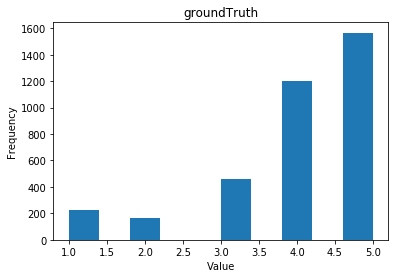

In [0]:
plt.hist(hotelDf['ratingScore'].values)
plt.title('groundTruth')
plt.xlabel("Value")
plt.ylabel("Frequency")
fig = plt.gcf()

### Vader score distribution

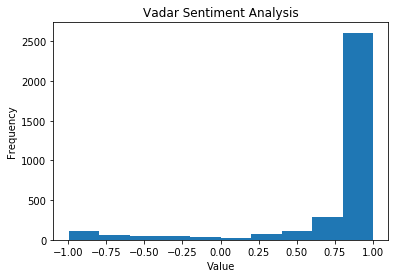

In [0]:
plt.hist(newdf['VaderScore'].values)
plt.title('Vadar Sentiment Analysis')
plt.xlabel("Value")
plt.ylabel("Frequency")
fig = plt.gcf()

#### Number of comments per hotel

In [0]:
hotel_count = []
for hotel in RatingDf_GT['hotelName']:
    count = sum(newdf.hotelName==hotel)
    occurance = count*[hotel] #each user has a list
    hotel_count.extend(occurance)

In [0]:
f = pd.factorize(hotel_count)

In [0]:
f[0] # I convert the hotel name to int from most popular (left) to less popular (right)

array([ 0,  0,  0, ..., 69, 69, 69], dtype=int64)

In [0]:
hotel_ID = []
for i in range(70):
    hotel_ID.append(i)
hotel_ID.append(70)

Text(0.5,1,'histogram showing the number of ratings per hotel from most popular(left) to less popular(right)')

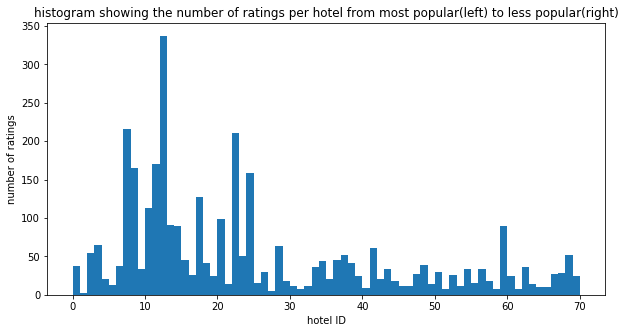

In [0]:
plt.figure(figsize =(10,5))
plt.hist(f[0], bins=hotel_ID)
plt.xlabel('hotel ID')
plt.ylabel('number of ratings')
plt.title('histogram showing the number of ratings per hotel from most popular(left) to less popular(right)')

In conclusion, more popular hotels tend to have much more reviews.

### Rating score box plot

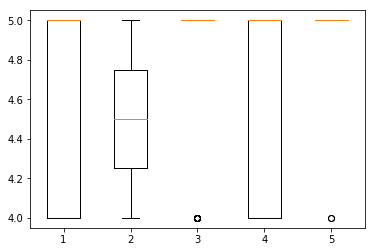

In [0]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = RatingDf_GT.sort_values('avg GT sentiment',ascending=0).head(5)
tp5gthotel['hotelName'].values

Residence_Inn_Marriott = hotelDf.loc[hotelDf['hotelName'] == tp5gthotel['hotelName'].values[0]]['ratingScore']
Wingate_by_Wyndham = hotelDf.loc[hotelDf['hotelName'] == tp5gthotel['hotelName'].values[1]]['ratingScore']
Marriott_Downtown = hotelDf.loc[hotelDf['hotelName'] == tp5gthotel['hotelName'].values[2]]['ratingScore']
Courtyard_by_Marriott = hotelDf.loc[hotelDf['hotelName'] == tp5gthotel['hotelName'].values[3]]['ratingScore']
Hotel_Elan = hotelDf.loc[hotelDf['hotelName'] == tp5gthotel['hotelName'].values[4]]['ratingScore']

data = [Residence_Inn_Marriott, Wingate_by_Wyndham, Marriott_Downtown, Courtyard_by_Marriott, Hotel_Elan]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

#### Mean and variance of the ground truth and Vader sentiment scores for the top-5 ranked hotels

In [0]:
hotels_mean = []
hotels_variance = []
for hotel in [Residence_Inn_Marriott, Wingate_by_Wyndham, Marriott_Downtown, Courtyard_by_Marriott, Hotel_Elan]:
    hotels_mean.append(hotel.mean())
    hotels_variance.append(hotel.var())

In [0]:
hotels_comparison = pd.DataFrame({'mean': hotels_mean, 'variance': hotels_variance})
hotels_comparison.rename(index = {0: tp5gthotel['hotelName'].values[0], 1:tp5gthotel['hotelName'].values[1], 
                                  2:tp5gthotel['hotelName'].values[2], 3:tp5gthotel['hotelName'].values[3],
                                 4:tp5gthotel['hotelName'].values[4]}, 
                                 inplace = True)

In [0]:
hotels_comparison.sort_values('mean', ascending=0)

,mean,variance
Hotel Elan,4.909091,0.086580
Calgary Marriott Downtown Hotel,4.763636,0.183838
Residence Inn by Marriott Calgary Airport,4.710526,0.211238
Courtyard by Marriott Calgary Airport,4.615385,0.240385
Wingate by Wyndham Calgary South,4.500000,0.500000


Mean and variance are more infomative. Because they are so similar that box plot can hardly tell the difference.

### Rating vs. Vader score

In [0]:
from scipy.stats.kde import gaussian_kde
def getheatmap(x,y,xlabel,ylabel):
    k = gaussian_kde(np.vstack([x, y]))
    xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j, y.min():y.max():y.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    fig = plt.figure(figsize=(6,8))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
    ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

    ax1.set_xlim(x.min(), x.max())
    ax1.set_ylim(y.min(), y.max())
    ax2.set_xlim(x.min(), x.max())
    ax2.set_ylim(y.min(), y.max())

    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)

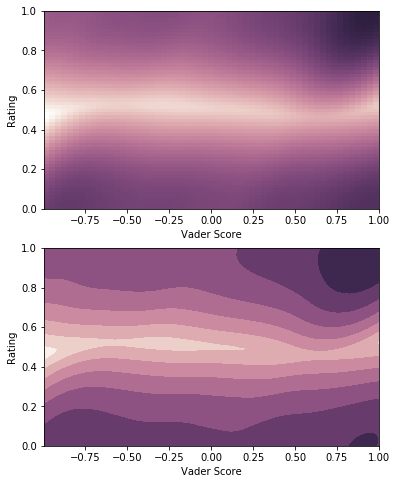

In [0]:
getheatmap(x,y,'Vader Score','Rating')

We can see the reviews have highest vader always have having rating.

### Length of reviews vs. Rating vs. Vader score

Text(0.5,0,'Rating')

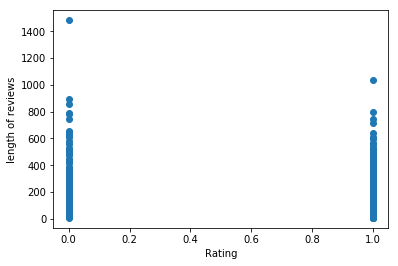

In [0]:
y_ii = [len(s.split()) for s in newdf.Review]
x_ii = newdf['ratingScore'].values
plt.plot(x_ii, y_ii, 'o')
plt.ylabel('length of reviews')
plt.xlabel('Rating')

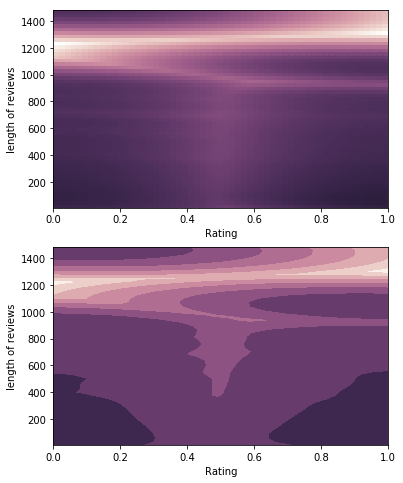

In [0]:
getheatmap(np.array(x_ii),np.array(y_ii),'Rating','length of reviews')

Negative reviews tend to be slightly longer.

Text(0.5,0,'Vader Rating')

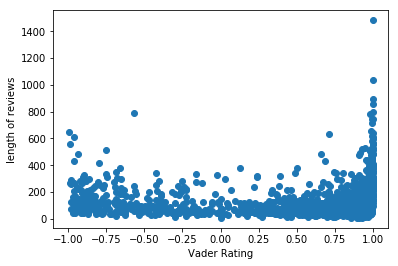

In [0]:
y_ii = [len(s.split()) for s in newdf.Review]
x_ii_new = newdf['VaderScore'].values
plt.plot(x_ii_new, y_ii,"o")
plt.ylabel('length of reviews')
plt.xlabel('Vader Rating')

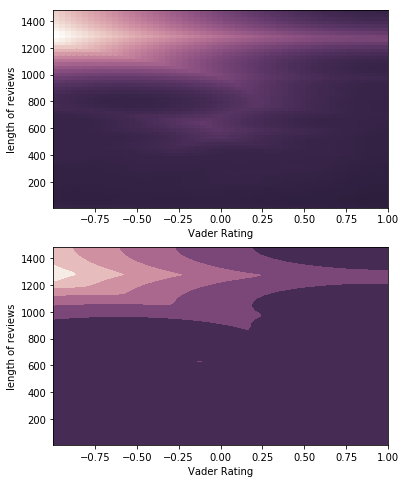

In [0]:
getheatmap(np.array(x_ii_new),np.array(y_ii),'Vader Rating','length of reviews')

Review with larger vader ratings tend to be longer.